# Sinusoidal Regression

The purpose of this notebook is to test and discuss the theory and application of a type of non-linear regression for sinusoidal data. If we are given some form of data, we would like to form a prediction curve that would help us capture the intricate patterns and shapes of our data, regardless of how noisy the data is. My goal is to explain and understand the mathematical theory behind sinusoidal regression, as well as apply with a visual example in pyhthon, with numpy and specifically visualizing it with the powerful tool, Plotly. I would also like to establish a good measure of fit variable, such as $R^2$ as well as a confidence interval said variable. 

## TOC:
* [Mathematical Theory](#math)
    * [Measuring Goodness of Fit/Model Accuracy](#fit)
    * [Links to Dive Deeper into](#dive)
* [Application in Python](#Python)
    * [Finding Parameters for Model](#find)
    * [Finding $S^2$](#s2)
    * [Finding $\chi^2_{red}$](#chi2red)
* [Plotting in Python using Plotly](#Plotly)
    * [QQplot](#QQplot)
* [Using Real Data Provided by Dr. Cudmore and the Santana Lab](#realdata)

## Mathematical Theory <a class="anchor" id="math"></a>

The definition of a sinusoidal model is one where we approximate some $Y_i$ with the following equation:
$$
Y_i = C + \alpha sin(\omega T_i + \phi_) + E_i
$$
Where $C$ is a constant defining our **mean** level, $\alpha$ is the amplitude, $\omega$ is the frequency, $T_i$ is our time variable, $\phi$ is the phase, and $E_i$ is the error sequence in approximation of $Y_i$.
From what I have read, the first step to sinusoidal regression is that we are making an initial "guess" as of the paramters will fit the data. Generally, we can start with $C$ being the mean of our data. We can generate a starting estimate of the amplitude $\alpha$ of our data with the root mean square multtiplied by the square root of two. 

https://en.wikipedia.org/wiki/Sinusoidal_model
https://en.wikipedia.org/wiki/Root_mean_square
https://en.wikipedia.org/wiki/Non-linear_least_squares

To understand the Stack overflow method, I will need to understand what the discrete Fourier Transform is and its application to this process. 

### Measuring Goodness of Fit/Model Accuracy<a class="anchor" id="fit"></a>

#### An Argument for $S^2$

Perhaps the biggest challenge so far in research is finding information on a value to describe the measure of fit for a model. As some sources suggest, $R^2$ seems to be an invalid when referring to non-linear models. Perhaps a better measure would be the residuals, which we would also expect to be random in our data. 

https://statisticsbyjim.com/regression/r-squared-invalid-nonlinear-regression/
https://statisticsbyjim.com/regression/standard-error-regression-vs-r-squared/

It appears we can also use standard error of the regression for ~~confidence~~ prediction intervals, which is ideal for our sinusoidal regression. The standard error of regression, which we can refer to a $s$ is derived by the following process: 
$$
s^2 = \frac{\hat{\epsilon}^T\hat{\epsilon}}{n-p}
$$
Where 
$$
   \hat{\epsilon} = y - \hat{y}
$$
We find $s$ by taking the square root of the $s^2$ solved for. This value s represents the average distance that our observed values $y$ are located from the regression line. Ideally we want $s$ to be minimized by our model. 

https://statisticsbyjim.com/glossary/standard-error-regression/

https://en.wikipedia.org/wiki/Ordinary_least_squares

#### A More Logical Goodness of Fit: Chi - Squared $\chi^2$

https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic

Directly related to our $s^2$ statistic, the reduced Chi-Squared statistic can help us give a better measure of fit that is easier to quantifiably compare beyond the concept of minimization. How does this statistic differ from the standard error of regression? Lets we write:
$$
\hat{\epsilon} = y - \hat{y}
$$
as...
$$
\hat{\epsilon} = Observed - Expected
$$
Such that we can think of a new statistic, $\chi^2$, as 
$$
\chi^2 = \sum_{i=1}^{n} \frac{(Obs_i - Exp_i)^2} {Exp_i} = \sum_{i=1}^{n} \frac{\epsilon^2}{Exp_i}
$$

We can create the reduced version of this statistic: 
$$
\chi^2_{red} = \frac{\chi^2}{\nu}
$$
Where...
$$
\nu = n - p
$$
where n is the number of observations and p is the number of parameters, which in the case of the electrophysiological data we are analyzing, would be 1. 

#### How is $\chi^2_{red}$ Better?

What makes this new statistic ideal is that we now can compare to this statistic to a value of refernce to draw conclusions about our model fit, and conveniently, that reference value is 1. If our reduced chi squared statistic is larger than one, than we can conclude that our model is a poor fit for the data. If our value is approximately 1, then our model is a good fit for the data. Lastly, if the statistic is lower than 1, we can conclude that perhaps we are overfitting the data. 

### Links to Dive Deeper into  <a class="anchor" id="dive"></a>

https://math.stackexchange.com/questions/2368821/find-a-sinusoidal-regression-equation-for-some-given-data

**Gauss-Newtown** algorithm
https://math.stackexchange.com/questions/301194/given-a-data-set-how-do-you-do-a-sinusoidal-regression-on-paper-what-are-the-e

**Hypothesis Testing and Model Fitting** http://astronomy.swin.edu.au/~cblake/StatsLecture3.pdf

**Chi-Squared and Basics** https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2018/Lecture1_Basics_ChiSquare.pdf

**Dos and don’ts of reduced chi-squared** https://arxiv.org/pdf/1012.3754.pdf



## Application in Python <a class="anchor" id="math"></a>

The stack overflow answer provides a method for implementing a sine curve, without initial guesses. 

https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy

https://towardsdatascience.com/fitting-cosine-sine-functions-with-machine-learning-in-python-610605d9b057

As mentioned in Towards Data Science, one of the ways to do a sinusoidal regression in python is using scipy *optimize.curve_fit*. This method uses an algorithm called the Trust Region Reflective algorithm. 

### Finding Parameters for Model  <a class="anchor" id="find"></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize

In [62]:
def fit_sin(tt, yy):
    # declaring response and explanatory variables as numpy arrays
    tt = np.array(tt)  # xdata
    yy = np.array(yy)  # ydata

    # np.fft computes the  one-dimensional discrete Fourier Transform
    # np.fft.fftfreq returns Discrete Fourier Transform sample frequencies
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))

    # Preliminary guesses of the parameters of sine function (this will not fit well)
    guess_freq = abs(
        ff[np.argmax(Fyy[1:]) + 1]
    )  # excluding the zero frequency "peak", which is related to offset
    guess_amp = (
        np.std(yy) * 2.0 ** 0.5
    )  # this uses the standard deviation rather than the root mean square, might want to investigate which is better
    guess_offset = np.mean(yy)  # guessing the constant C with the mean of the data
    guess = np.array([guess_amp, 2.0 * np.pi * guess_freq, 0.0, guess_offset])

    def sinfunc(t, A, w, p, c):
        return (
            A * np.sin(w * t + p) + c
        )  # this one-liner returns the format for the sin equation

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    # Scipy.optimize takes multiple parameters to fit non-linear data, p0 is an optional variable for guess of parameters
    # optimize returns 2 objects: popt is optimal values for paramters where SQUARED RESIDUALS are minimized
    # pcov is a 2-D array that is the estimated covariance of popt

    popt, pcov = scipy.optimize.curve_fit(f=sinfunc, xdata=tt, ydata=yy, p0=guess)
    A, w, p, c = popt  # takes the optimized variables
    f = w / (
        2.0 * np.pi
    )  # still need to understand why omega is divided by 2pi, radian conversion?
    fitfunc = (
        lambda t: A * np.sin(w * t + p) + c
    )  # lambda function to build sin expression
    origRes = {
        "amp": A,
        "omega": w,
        "phase": p,
        "offset": c,
        "freq": f,
        "period": 1.0 / f,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov),
    }

    # Now putting data into cleaner Pandas DF for output
    paramDict = {
        "Amplitude": A,
        "Omega": w,
        "Phase": p,
        "Offset": c,
        "Frequency": f,
        "Period": 1.0 / f,
        "Max Cov.": np.max(pcov),
    }
    statTable = pd.DataFrame(paramDict, index=[0]).T
    statTable.columns = ["Parameters"]  # renaming column index
    return statTable

<IPython.core.display.Javascript object>

In [64]:
### Simulation
N, amp, omega, phase, offset, noise = 500, 1.0, 2.0, 0.5, 4.0, 3

tt = np.linspace(0, 10, N)
tt2 = np.linspace(0, 10, 10 * N)
yy = amp * np.sin(omega * tt + phase) + offset
yynoise = yy + noise * (np.random.random(len(tt)) - 0.5)

res = fit_sin(tt, yynoise)
res
# print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

,Parameters
Amplitude,1.037746
Omega,2.024070
Phase,0.422842
Offset,4.006438
Frequency,0.322141
Period,3.104233
Max Cov.,0.011828


<IPython.core.display.Javascript object>

### Finding $S^2$   <a class="anchor" id="s2"></a>

In [65]:
# Writing a function that finds statistic s, the standard error of the regression, via a short function. Note: This will not work for anything data sets beyond 2 dimensional.


def find_s(y, yhat):
    epsilon = y - yhat
    s2 = np.dot(epsilon, epsilon.T) / (yynoise.size - 1)
    s = np.sqrt(s2)
    return s


# Test
find_s(yynoise, yy)

# Recall that s is not some proportional value like an R^2, there is no maximum, this simply means that 0.88 is the aeverage distance from the prediction curve and the actual observed value

0.8498330398525376

<IPython.core.display.Javascript object>

### Finding $\chi^2_{red}$ <a class="anchor" id="chi2red"></a>

In [66]:
# Function that finds reduced chi squared
import scipy.stats as stats


def find_chi(y, yhat):
    obs, exp = y, yhat
    chisq, p = stats.chisquare(f_obs=obs, f_exp=exp)
    red_chi = chisq / (
        len(y) - 4
    )  # NOTE: The denominator is the degrees of freedom, 4 becuase 4 params, amp, ang freq, phase, and offset
    return red_chi


find_chi(yynoise, yy)

0.184370347416138

<IPython.core.display.Javascript object>

Next approach I would like to try, since I have no idea what the distribution of the residuals would be yet (I will look into doing a QQplot and see if the distribution of residuals is normal), bootstrapping might be the answer.

https://www.geeksforgeeks.org/qqplot-quantile-quantile-plot-in-python/

https://stats.stackexchange.com/questions/112829/how-do-i-calculate-confidence-intervals-for-a-non-normal-distribution

https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/regression/how-to/nonlinear-regression/interpret-the-results/all-statistics-and-graphs/residual-plots/

## Plotting in Python using Plotly <a class="anchor" id="Plotly"></a>

https://plotly.com/python/graphing-multiple-chart-types/


In [69]:
# First, download plotly
#!pip install plotly==5.4.0
#!pip install cufflinks
#!pip install chart_studio

<IPython.core.display.Javascript object>

In [70]:
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import *
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

<IPython.core.display.Javascript object>

In [71]:
fig = px.scatter(x=tt, y=yynoise)
fig.add_scatter(x=tt, y=yy, name="Sinusoidal Prediction")
fig.update_layout(title="Sinsusoidal Regression on Noisy Data")
fig.show()

<IPython.core.display.Javascript object>

### QQPlot  <a class="anchor" id="QQplot"></a>

In [72]:
fig = go.Figure()

# Scatter plot of the residuals
fig.add_trace(
    {
        "type": "scatter",
        "x": qqplot_data[0].get_xdata(),
        "y": qqplot_data[0].get_ydata(),
        "mode": "markers",
        "marker": {"color": "#19d3f3"},
    }
)

# Adds Symmetric Line
fig.add_trace(
    {
        "type": "scatter",
        "x": qqplot_data[1].get_xdata(),
        "y": qqplot_data[1].get_ydata(),
        "mode": "lines",
        "line": {"color": "#636efa"},
    }
)

# Adds legend and labeling
fig["layout"].update(
    {
        "title": "Quantile-Quantile Plot",
        "xaxis": {"title": "Theoritical Quantities", "zeroline": False},
        "yaxis": {"title": "Sample Quantities"},
        "showlegend": False,
        "width": 800,
        "height": 700,
    }
)

# Shows the plot
offline.iplot(fig, filename="normality-QQ")

<IPython.core.display.Javascript object>

### Using Real Data Provided by Dr. Cudmore and the Lab <a class="anchor" id="realdata"></a>

this is what our loaded file looks like, it has 749 rows.
              filename  sweep  peakPhase
0  2021_12_06_0005.abf      0     0.1374
1  2021_12_06_0005.abf      0     0.3149
2  2021_12_06_0005.abf      0     0.1669
3  2021_12_06_0005.abf      0     0.2657
4  2021_12_06_0005.abf      0     0.1695

and here it is grouped by ['filename', 'sweep'] ...
                          peakPhase                                       \
                              count   median      mean       std     min   
filename            sweep                                                  
2021_12_06_0005.abf 0            16  0.18950  0.282444  0.213297  0.1374   
                    1            16  0.12675  0.139981  0.070702  0.0211   
                    2            16  0.22565  0.232331  0.086714  0.0955   
                    3            10  0.13550  0.290550  0.303331  0.0447   
2021_12_09_0011.abf 0            66  0.51760  0.499932  0.292664  0.0172   
                    1            63

           Parameters
Amplitude   -0.268247
Omega        1.939097
Phase       -1.946474
Offset       0.495495
Frequency    0.308617
Period       3.240263
Max Cov.     0.086077
0.1029218201362409
           Parameters
Amplitude   -0.211135
Omega        1.880920
Phase        1.605376
Offset       0.467891
Frequency    0.299358
Period       3.340485
Max Cov.     0.194675
0.156275866091211
           Parameters
Amplitude   -0.300097
Omega        1.950177
Phase       -0.023157
Offset       0.470873
Frequency    0.310380
Period       3.221853
Max Cov.     0.052577
0.09303942418276438
           Parameters
Amplitude   -0.275945
Omega        1.533904
Phase        1.093199
Offset       0.461716
Frequency    0.244128
Period       4.096206
Max Cov.     0.066274
0.1110145431303128
           Parameters
Amplitude   -0.277747
Omega        1.769660
Phase        0.591971
Offset       0.482446
Frequency    0.281650
Period       3.550504
Max Cov.     0.067233
0.1121169616619399


           Parameters
Amplitude    0.172196
Omega        2.663335
Phase        0.590095
Offset       0.455440
Frequency    0.423883
Period       2.359142
Max Cov.     0.252003
0.17042800124169663
           Parameters
Amplitude    0.159677
Omega        2.648282
Phase        0.802825
Offset       0.475667
Frequency    0.421487
Period       2.372551
Max Cov.     0.296668
0.15989669388832134
             Parameters
Amplitude  6.438937e+00
Omega      3.141870e+00
Phase     -2.133348e-02
Offset     4.846286e-01
Frequency  5.000442e-01
Period     1.999823e+00
Max Cov.   2.105244e+09
0.1728524040083635
             Parameters
Amplitude  7.682830e+00
Omega      3.141299e+00
Phase      2.758499e-02
Offset     5.551714e-01
Frequency  4.999532e-01
Period     2.000187e+00
Max Cov.   2.815595e+09
0.11089347793773875
           Parameters
Amplitude    0.180157
Omega        2.750250
Phase        0.008554
Offset       0.481128
Frequency    0.437716
Period       2.284587
Max Cov.     0.246357
0.1579780

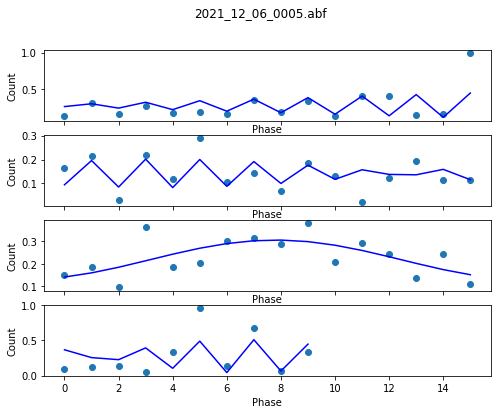

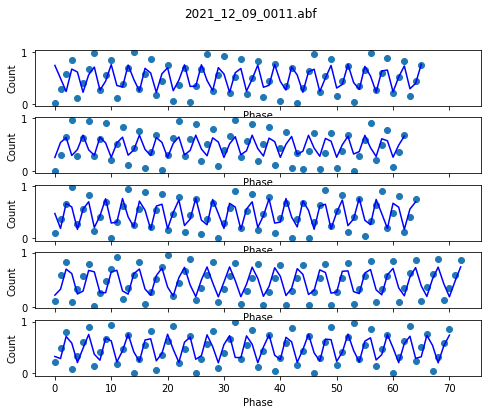

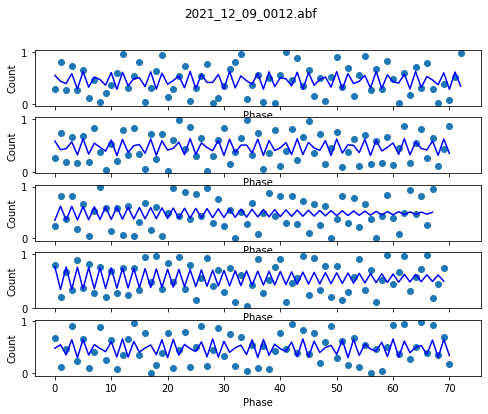

<IPython.core.display.Javascript object>

In [74]:
### TO DO: Make subplots and change matplot plotting to plotly plots

url = "https://raw.githubusercontent.com/gspiga/Cudmore/main/SinusoidalRegress/gianni-master-20220104.csv"
dfFile = pd.read_csv(url)
dfFile.head()


def plotOneFile(df, filename: str):
    """
    Plot each file in a figure with subplots corresponding to sweep

    Args:
        df (dataframe): Pandas dataframe with columns ['filename', 'sweeps', peakPhase']
        filename (str): Name of file to plot.

    Notes:
        This is bad form as I am mixing code for plotting and analysis.
    """

    dfFile = df[df["filename"] == filename]  # grab specified filename
    sweeps = dfFile["sweep"].unique()  # get list of sweeps [0, 1, 2, ...]

    numSubplot = len(sweeps)

    fig1 = make_subplots(rows=5, cols=1, x_title="Phase", y_title="Count")  # plotly
    fig1.update_layout(title_text=filename)

    fig, axs = plt.subplots(numSubplot, 1, sharex=True, figsize=(8, 6))
    fig.suptitle(filename)

    for idx, sweep in enumerate(sweeps):

        dfSweep = dfFile[dfFile["sweep"] == sweep]  # grab one sweep from one file
        peakPhase = dfSweep["peakPhase"]  # grab the raw data

        # trying to add something here to maybe make a psuedo time variable for x axis, Ill use the index
        ourIndex = list(range(0, len(peakPhase)))

        # selecting appropriate bins is important
        # lots of different algorithms, not sure which one is best
        # see: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
        bins = "auto"

        # plot the histogram and grab its data
        # counts, bins, bars = axs[idx].hist(peakPhase, bins=bins)

        #
        # TODO: Do a sine fit of x=bins and y=counts
        #
        # Lets tackle this sine fit

        # Bins and counts arent the same length, so it did not work
        axs[idx].scatter(ourIndex, peakPhase)

        # Plotly adding points of actual data
        fig1.add_trace(
            go.Scatter(
                x=ourIndex,
                y=peakPhase,
                mode="markers",
                line=dict(color="#008080"),
                showlegend=False,
            ),
            row=idx + 1,
            col=1,
        )
        fig1.update_traces(
            connectgaps=False
        )  # this prevents the actual data from creating a line

        res = fit_sin(ourIndex, peakPhase)
        print(res)
        #         print(
        #             "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res)
        # print(type(ourIndex))
        
        # Going about plotting the sine curve
        x = np.asarray(ourIndex)

        y = (
            res.loc["Amplitude", "Parameters"]
            * np.sin(
                res.loc["Omega", "Parameters"] * x + res.loc["Phase", "Parameters"]
            )
            + res.loc["Offset", "Parameters"]
        )
        axs[idx].plot(ourIndex, y, "b")

        # plotly adding sinusoidal prediction
        fig1.add_trace(
            go.Scatter(x=ourIndex, y=y, line=dict(color="#0000FF"), showlegend=False),
            row=idx + 1,
            col=1,
        )
        print(find_chi(peakPhase, y))
        axs[idx].set_ylabel("Count")
        axs[idx].set_xlabel(
            "Phase"
        )  # This is phase within a sin wave (we don't know the frequency)

    return fig1.show()


def run(path: str):
    """
    Each 'filename' is a different recording
        Within each recording we have a number of different sweeps ('sweep')
            Within each sweep are 'peakPhase' values to analyze/fit

    Args:
        path (str): Full path to csv file for analysis.
    """

    # load the file
    df = pd.read_csv(path)

    # check the format of loaded csv
    print(f"this is what our loaded file looks like, it has {len(df)} rows.")
    print(df.head())

    # print some stats
    aggList = ["count", "median", "mean", "std", "min", "max"]
    dfTmp = df.groupby(["filename", "sweep"]).agg(aggList)
    print("")
    print("and here it is grouped by ['filename', 'sweep'] ...")
    print(dfTmp)

    # plot each file in a figure with subplots corresponding to sweep
    filenames = df["filename"].unique()
    for filename in filenames:
        plotOneFile(df, filename)

        #
    plt.show()


if __name__ == "__main__":
    #
    # change this to location of your csv file
    #
    # path = '/home/cudmore/Sites/SanPy/colin/gianni-master.csv'

    # Laptop G
    # path = "C:/Users/Gianni/Desktop/Github/Cudmore/SinusoidalRegress/gianni-master-20220104.csv"

    # Desktop G
    path = "C:/Users/Gianni/Documents/GitHub/Cudmore/SinusoidalRegress/gianni-master-20220104.csv"
    run(path)